In [1]:
import re
import nltk

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from nltk.tokenize import word_tokenize

from tqdm.auto import tqdm

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kirillanpilov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Функция обучения

In [3]:
def train(model, optimizer, criterion, n_epochs, train_loader, test_loader):

  loss_train = []
  accuracy_train = []

  for epoch in range(n_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{n_epochs}"):
        inputs = batch["input"]
        labels = batch["label"]
        output = model(inputs)

        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
      for batch in tqdm(test_loader, desc=f"Testing epoch {epoch + 1}/{n_epochs}"):
        inputs = batch["input"]
        labels = batch["label"]
        output = model(inputs)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    accuracy_train.append(test_accuracy)
    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
    loss_train.append(loss.item())


## Фунцкия матрицы несоответствия

In [4]:
def matrix_confusion(model, test_loder, list_classes):
    true_labels = []
    predicted_labels = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in test_loder:
            inputs = batch["input"]
            labels = batch["label"]
    
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
    
            true_labels.extend(labels.numpy())
            predicted_labels.extend(predicted.numpy())
    
    correct = (np.array(true_labels) == np.array(predicted_labels)).sum()
    accuracy = correct / len(true_labels)
    print(f"Test Accuracy: {accuracy:.2%}")
    
    confusion = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=list_classes, yticklabels=list_classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## 1. Представление и предобработка текстовых данных

### 1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [6]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [53]:
def preprocess_text(text: str):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z .,!?]',' ', text)
    text = re.sub('\n',' ', text)

    return text


In [54]:
preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

### 1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [9]:
def one_hot_sen(text: str) -> torch.Tensor():
    #vocab of unique words
    vocab = list(set(word_tokenize(text)))

    #First sentence
    sen1 = sent_tokenize(text)[0]

    #zero tensor
    tensor_sen = torch.zeros(len(vocab))

    for word in word_tokenize(sen1):
        tensor_sen[vocab.index(word)] = 1

    return tensor_sen


In [10]:
one_hot_sen(text)

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0.])

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

### 2.1 Считать файл `surnames/surnames.csv`.


In [11]:
surnames_df = pd.read_csv('surnames.csv')

In [12]:
surnames_df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### Баланс классов

In [13]:
surnames_df['nationality'].value_counts()

nationality
English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: count, dtype: int64

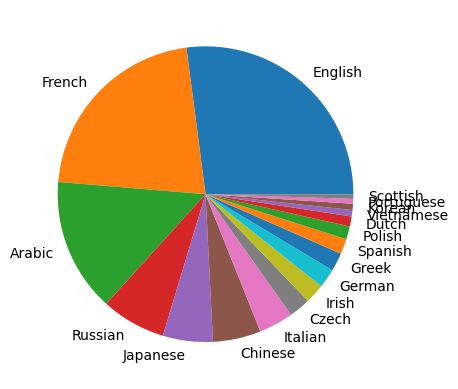

In [14]:
plt.pie(surnames_df['nationality'].value_counts(), labels =  surnames_df['nationality'].unique())
plt.show()

In [15]:
oversampled_data = pd.DataFrame(columns=surnames_df.columns)


for class_label in surnames_df['nationality'].unique():
    class_data = surnames_df[surnames_df['nationality'] == class_label]
    oversampled_class = resample(class_data, replace=True, n_samples=3000)
    oversampled_data = pd.concat([oversampled_data, oversampled_class], axis=0)

oversampled_class_distribution = oversampled_data['nationality'].value_counts()
print("\nClass Distribution After Oversampling:")
print(oversampled_class_distribution)


Class Distribution After Oversampling:
nationality
English       3000
French        3000
Portuguese    3000
Korean        3000
Vietnamese    3000
Dutch         3000
Polish        3000
Spanish       3000
Greek         3000
German        3000
Irish         3000
Czech         3000
Italian       3000
Chinese       3000
Japanese      3000
Russian       3000
Arabic        3000
Scottish      3000
Name: count, dtype: int64


In [16]:
surnames_df = oversampled_data

In [17]:
surnames_df

,surname,nationality
9563,Gunn,English
5747,Cawley,English
3248,Kenny,English
10054,Wrightson,English
6773,Keay,English
...,...,...
6546,Millar,Scottish
9668,White,Scottish
7632,Munro,Scottish
1886,Docherty,Scottish


### 2.2 Закодировать национальности числами, начиная с 0.


In [18]:
le = LabelEncoder()
le.fit(surnames_df['nationality'])
surnames_df['nationality'] = le.transform(surnames_df['nationality'])
surnames_df.head()

,surname,nationality
9563,Gunn,4
5747,Cawley,4
3248,Kenny,4
10054,Wrightson,4
6773,Keay,4


In [19]:
print(le.classes_)

['Arabic' 'Chinese' 'Czech' 'Dutch' 'English' 'French' 'German' 'Greek'
 'Irish' 'Italian' 'Japanese' 'Korean' 'Polish' 'Portuguese' 'Russian'
 'Scottish' 'Spanish' 'Vietnamese']


### 2.3 Разбить датасет на обучающую и тестовую выборку


In [20]:
X_train, X_test, y_train, y_test = train_test_split(surnames_df['surname'], surnames_df['nationality'] , test_size=0.25, random_state=42)

### 2.4 Реализовать класс `Vocab` (токен = __символ__)


In [21]:
class Vocab:
    def __init__(self, data: pd.Series):
        self.data = data
        self.token_to_idx = self.create_vocab(self.data)
        self.idx_to_token = {token: symbol for symbol, token  in self.token_to_idx.items()}
        self.vocab_len = len(self.token_to_idx)


    def create_vocab(self, data):
        token_to_idx = {}
        str_data = " ".join(data)
        tokenizer = 0
        for symbol in str_data:
            if symbol not in token_to_idx:
                token_to_idx[symbol] = tokenizer
                tokenizer += 1

        return token_to_idx


In [22]:
vocab = Vocab(X_train)
vocab.token_to_idx

{'R': 0,
 'o': 1,
 'm': 2,
 'i': 3,
 'j': 4,
 'n': 5,
 ' ': 6,
 'O': 7,
 'p': 8,
 'h': 9,
 'v': 10,
 'e': 11,
 'K': 12,
 'z': 13,
 'l': 14,
 'w': 15,
 's': 16,
 'k': 17,
 'M': 18,
 'u': 19,
 't': 20,
 'c': 21,
 'B': 22,
 'f': 23,
 'C': 24,
 'r': 25,
 'L': 26,
 'é': 27,
 'H': 28,
 'a': 29,
 'd': 30,
 'D': 31,
 'G': 32,
 'P': 33,
 'N': 34,
 'g': 35,
 'q': 36,
 "'": 37,
 'S': 38,
 'T': 39,
 'y': 40,
 'J': 41,
 'A': 42,
 'b': 43,
 'I': 44,
 'U': 45,
 'F': 46,
 'x': 47,
 'W': 48,
 'Y': 49,
 'è': 50,
 'Z': 51,
 'E': 52,
 'à': 53,
 'á': 54,
 'ú': 55,
 'ñ': 56,
 'V': 57,
 'Q': 58,
 'É': 59,
 'õ': 60,
 'í': 61,
 'Ś': 62,
 'ó': 63,
 'ü': 64,
 'X': 65,
 'ä': 66,
 'ã': 67,
 '-': 68,
 'ö': 69,
 '/': 70,
 'ż': 71,
 '1': 72,
 ':': 73,
 'Á': 74,
 'ń': 75,
 'ç': 76,
 'ß': 77,
 'Ż': 78,
 'ł': 79,
 'ì': 80,
 'ą': 81,
 'ê': 82,
 'ù': 83,
 'ò': 84}

### 2.5 Реализовать класс `SurnamesDataset`

In [23]:
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname):
        surname_tensor = torch.zeros(self.vocab.vocab_len)

        for symbol in surname:
            surname_tensor[self.vocab.token_to_idx[symbol]] = 1

        return surname_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {"input" : self.vectorize(self.X[idx]) , "label" : self.y[idx]}

In [24]:
vocab = Vocab(surnames_df['surname'])

surnames_dataset_train = SurnamesDataset(X_train.values, y_train.values, vocab)
surnames_dataset_test= SurnamesDataset(X_test.values, y_test.values, vocab)

### 2.6. Обучить классификатор.

In [25]:
surnames_dataloader_train = DataLoader(surnames_dataset_train, batch_size = 64, shuffle= True)
surnames_dataloader_test = DataLoader(surnames_dataset_test, shuffle= True)

#### Просто модель с 3 линейными слоями

In [26]:
class Classficator(nn.Module):
  def __init__(self, input_dim, num_classes):
        super(Classficator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)  
        self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.relu(self.fc3(x))
    return x

In [27]:
surnames_dataloader_train.dataset[0]

{'input': tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'label': 3}

In [28]:
num_classes = len(set(surnames_dataloader_train.dataset.y)) # 18
input_dim = len(surnames_dataloader_train.dataset[0]['input']) # 85
n_epochs = 20

model = Classficator(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, criterion, n_epochs, surnames_dataloader_train, surnames_dataloader_test)

Training epoch 1/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 1/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [1/20], Loss: 1.7810, Test Accuracy: 39.62%


Training epoch 2/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 2/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [2/20], Loss: 2.1710, Test Accuracy: 43.74%


Training epoch 3/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 3/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [3/20], Loss: 2.1357, Test Accuracy: 45.81%


Training epoch 4/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 4/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [4/20], Loss: 1.5986, Test Accuracy: 48.96%


Training epoch 5/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 5/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [5/20], Loss: 1.4725, Test Accuracy: 50.91%


Training epoch 6/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 6/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [6/20], Loss: 2.0110, Test Accuracy: 52.56%


Training epoch 7/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 7/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [7/20], Loss: 1.3690, Test Accuracy: 53.88%


Training epoch 8/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 8/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [8/20], Loss: 1.4716, Test Accuracy: 54.59%


Training epoch 9/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 9/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [9/20], Loss: 1.6706, Test Accuracy: 55.47%


Training epoch 10/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 10/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [10/20], Loss: 1.4888, Test Accuracy: 56.50%


Training epoch 11/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 11/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [11/20], Loss: 1.4751, Test Accuracy: 57.14%


Training epoch 12/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 12/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [12/20], Loss: 1.3773, Test Accuracy: 57.70%


Training epoch 13/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 13/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [13/20], Loss: 1.3975, Test Accuracy: 58.73%


Training epoch 14/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 14/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [14/20], Loss: 1.1427, Test Accuracy: 58.99%


Training epoch 15/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 15/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [15/20], Loss: 1.4518, Test Accuracy: 59.39%


Training epoch 16/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 16/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [16/20], Loss: 1.6929, Test Accuracy: 59.50%


Training epoch 17/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 17/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [17/20], Loss: 1.2801, Test Accuracy: 60.55%


Training epoch 18/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 18/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [18/20], Loss: 1.3562, Test Accuracy: 60.26%


Training epoch 19/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 19/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [19/20], Loss: 1.1985, Test Accuracy: 60.39%


Training epoch 20/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 20/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [20/20], Loss: 1.5858, Test Accuracy: 60.13%


Test Accuracy: 60.13%


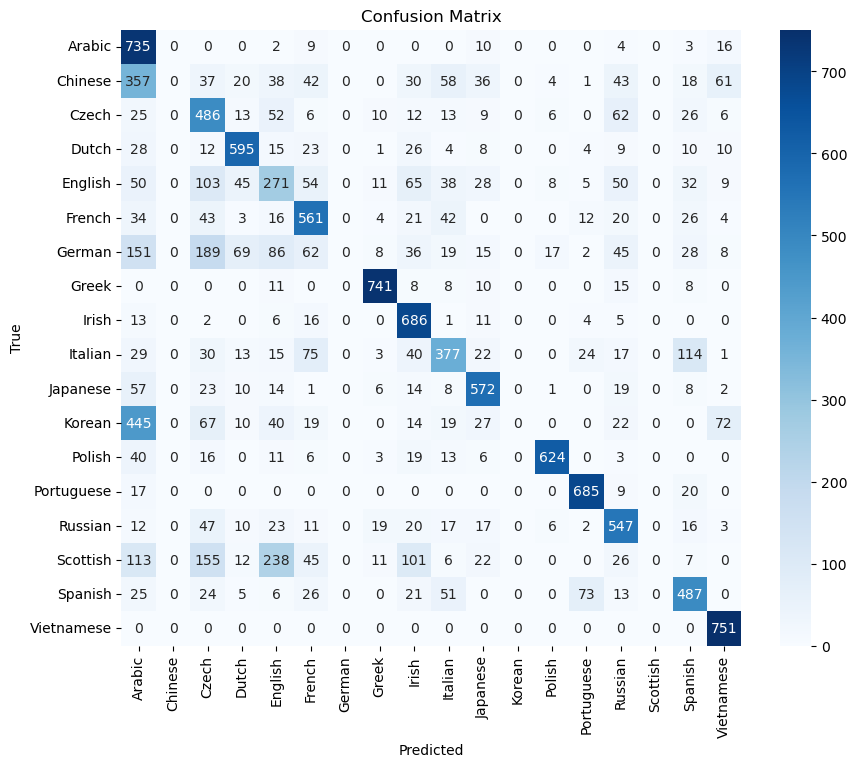

In [29]:
matrix_confusion(model, surnames_dataloader_test, le.classes_)

In [30]:
le.classes_

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese'], dtype=object)

In [32]:
model.eval()
surname = "Anpilov" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")

surname = "Kyserbaev" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")

surname = "Kuznetcova" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")

surname = "Axmad" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")

surname = "Gallo" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")


surname = "Pablo" 
output = model(surnames_dataset_train.vectorize(surname))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {surname} , Predicted label : { le.classes_[predicted]}")

Input: Anpilov , Predicted label : Russian
Input: Kyserbaev , Predicted label : Czech
Input: Kuznetcova , Predicted label : Greek
Input: Axmad , Predicted label : English
Input: Gallo , Predicted label : Spanish
Input: Pablo , Predicted label : Czech


#### Модель RNN

In [35]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        out = self.tanh(out)
        return out

In [36]:
num_classes = len(set(surnames_dataloader_train.dataset.y)) # 18
input_dim = len(surnames_dataloader_train.dataset[0]['input']) # 85

hidden_dim =85
n_epochs = 20

model = RNN(hidden_dim, input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, criterion, n_epochs, surnames_dataloader_train, surnames_dataloader_test)

Training epoch 1/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 1/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [1/20], Loss: 2.1801, Test Accuracy: 36.33%


Training epoch 2/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 2/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [2/20], Loss: 1.9646, Test Accuracy: 41.22%


Training epoch 3/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 3/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [3/20], Loss: 2.1454, Test Accuracy: 44.05%


Training epoch 4/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 4/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [4/20], Loss: 2.0046, Test Accuracy: 46.07%


Training epoch 5/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 5/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [5/20], Loss: 1.9174, Test Accuracy: 46.75%


Training epoch 6/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 6/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [6/20], Loss: 1.9106, Test Accuracy: 48.86%


Training epoch 7/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 7/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [7/20], Loss: 1.8091, Test Accuracy: 48.64%


Training epoch 8/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 8/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [8/20], Loss: 1.8548, Test Accuracy: 49.33%


Training epoch 9/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 9/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [9/20], Loss: 1.7480, Test Accuracy: 50.60%


Training epoch 10/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 10/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [10/20], Loss: 1.9293, Test Accuracy: 51.79%


Training epoch 11/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 11/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [11/20], Loss: 1.7842, Test Accuracy: 52.49%


Training epoch 12/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 12/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [12/20], Loss: 1.8823, Test Accuracy: 53.73%


Training epoch 13/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 13/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [13/20], Loss: 1.8583, Test Accuracy: 54.90%


Training epoch 14/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 14/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [14/20], Loss: 1.8554, Test Accuracy: 55.74%


Training epoch 15/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 15/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [15/20], Loss: 1.7396, Test Accuracy: 56.82%


Training epoch 16/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 16/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [16/20], Loss: 1.7017, Test Accuracy: 57.08%


Training epoch 17/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 17/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [17/20], Loss: 1.6030, Test Accuracy: 57.97%


Training epoch 18/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 18/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [18/20], Loss: 1.6034, Test Accuracy: 59.21%


Training epoch 19/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 19/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [19/20], Loss: 1.5789, Test Accuracy: 59.21%


Training epoch 20/20:   0%|          | 0/633 [00:00<?, ?it/s]

Testing epoch 20/20:   0%|          | 0/13500 [00:00<?, ?it/s]

Epoch [20/20], Loss: 1.5885, Test Accuracy: 59.95%


## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

### 3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

In [148]:
df_raw_train = pd.read_csv('raw_train.csv', names=["rating", "review"])

In [149]:
df_raw_train

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [150]:
df_raw_train['rating'] = df_raw_train['rating'] - 1

In [151]:
df_raw_train = df_raw_train.sample(frac=0.1, random_state=42) 
df_raw_train

,rating,review
34566,1,This place is one of my favorite comic shops. ...
223092,0,The wait time for an appointment is ridiculous...
110270,0,I did not like this hotel at all. It's very ol...
365013,1,Mill Avenue has a serious issue with parking. ...
311625,1,Favorite sushi place in NV! Price is reasonab...
...,...,...
213529,1,It's time for an update of CVS -\n\nIf you are...
241422,0,"I was in the area doing some shopping, and bot..."
141719,0,I did an all Venetian restaurant tour on my mo...
39372,1,"Great atmosphere, good food, profesional servi..."


### 3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

In [152]:
df_raw_train['review'] = df_raw_train['review'].map(lambda x: preprocess_text(x))
df_raw_train

,rating,review
34566,1,this place is one of my favorite comic shops. ...
223092,0,the wait time for an appointment is ridiculous...
110270,0,i did not like this hotel at all. it s very ol...
365013,1,mill avenue has a serious issue with parking. ...
311625,1,favorite sushi place in nv! price is reasonab...
...,...,...
213529,1,it s time for an update of cvs n nif you are...
241422,0,"i was in the area doing some shopping, and bot..."
141719,0,i did an all venetian restaurant tour on my mo...
39372,1,"great atmosphere, good food, profesional servi..."


In [153]:
df_raw_train['rating'].value_counts()

rating
0    28035
1    27965
Name: count, dtype: int64

### 3.3 Разбить датасет на обучающую и тестовую выборку

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_train['review'], df_raw_train['rating'] , test_size=0.25, random_state=42)

### 3.4 Реализовать класс `Vocab` (токен = слово)

In [133]:
class Vocab:
    def __init__(self, data: pd.Series):
        self.data = data
        self.token_to_idx = self.create_vocab(self.data)
        self.idx_to_token = {token: symbol for symbol, token  in self.token_to_idx.items()}
        self.vocab_len = len(self.token_to_idx)


    def create_vocab(self, data):
        token_to_idx = {}
        str_data = " ".join(data)
        token_to_idx["<unk>"] = 0
        tokenizer = 1
        
        for word in word_tokenize(str_data):
            if word not in token_to_idx:
                token_to_idx[word] = tokenizer
                tokenizer += 1

        return token_to_idx


### 3.5 Реализовать класс `ReviewDataset`

In [139]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        '''Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)'''
        review_tensor = torch.zeros(self.vocab.vocab_len)

        for word in word_tokenize(review):
            if word not in self.vocab.token_to_idx:
                review_tensor[self.vocab.token_to_idx["<unk>"]] = 1
            else:                
                review_tensor[self.vocab.token_to_idx[word]] = 1

        return review_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {"input" : self.vectorize(self.X[idx]) , "label" : self.y[idx]}

In [154]:
vocab = Vocab(df_raw_train['review'])

review_dataset_train = ReviewDataset(X_train.values, y_train.values, vocab)
review_dataset_test= ReviewDataset(X_test.values, y_test.values, vocab)

### 3.6 Обучить классификатор

In [141]:
review_dataloader_train = DataLoader(review_dataset_train, batch_size = 64, shuffle= True)
review_dataloader_test = DataLoader(review_dataset_test, batch_size = 1000, shuffle= True)

In [142]:
class Classficator(nn.Module):
  def __init__(self, input_dim, num_classes):
        super(Classficator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)  
        self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.relu(self.fc3(x))
    return x

In [143]:
len(review_dataloader_train.dataset[0]['input'])

72051

In [144]:
num_classes = 2 
input_dim = len(review_dataloader_train.dataset[0]['input'])
n_epochs = 10

model = Classficator(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, criterion, n_epochs, review_dataloader_train, review_dataloader_test)

Training epoch 1/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 1/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2206, Test Accuracy: 90.76%


Training epoch 2/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 2/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.2689, Test Accuracy: 91.88%


Training epoch 3/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 3/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.1018, Test Accuracy: 91.49%


Training epoch 4/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 4/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0031, Test Accuracy: 90.64%


Training epoch 5/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 5/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0007, Test Accuracy: 91.14%


Training epoch 6/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 6/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0392, Test Accuracy: 91.11%


Training epoch 7/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 7/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0000, Test Accuracy: 90.95%


Training epoch 8/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 8/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0004, Test Accuracy: 90.86%


Training epoch 9/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 9/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0032, Test Accuracy: 90.74%


Training epoch 10/10:   0%|          | 0/657 [00:00<?, ?it/s]

Testing epoch 10/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0003, Test Accuracy: 90.80%


### 3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [155]:
df_raw_test = pd.read_csv('raw_test.csv', names=["rating", "review"])
df_raw_test['rating'] = df_raw_test['rating'] - 1
df_raw_test['review'] = df_raw_test['review'].map(lambda x: preprocess_text(x))


review_dataset_valid = ReviewDataset(df_raw_test['review'].values, df_raw_test['rating'].values, vocab)
review_dataloader_valid = DataLoader(review_dataset_valid, batch_size = 1000, shuffle= True)

In [160]:
model.eval()

accuracy_train = []
correct = 0
total = 0

with torch.no_grad():
  for batch in tqdm(review_dataloader_valid, desc=f"Testing"):
    inputs = batch["input"]
    labels = batch["label"]
    output = model(inputs)
    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = correct / total
accuracy_train.append(test_accuracy)
print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))


Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Test Accuracy: 90.81%


Test Accuracy: 90.81%


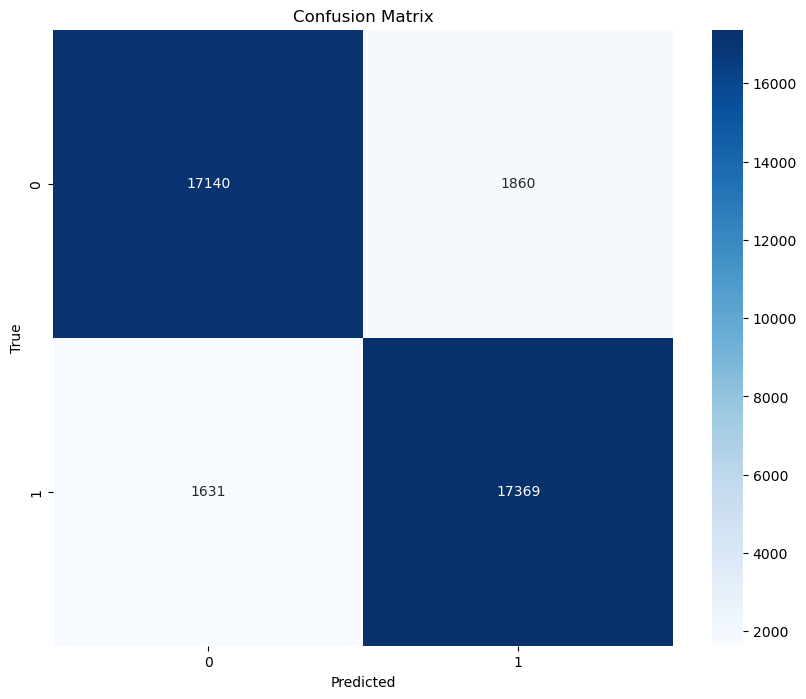

In [161]:
matrix_confusion(model, review_dataloader_valid, [0,1])

In [166]:
model.eval()
review = "I like this coffe, very good" 
output = model(review_dataset_train.vectorize(review))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {review} , Predicted label : { predicted}")

review = "Omg!, this place is horrible!" 
output = model(review_dataset_train.vectorize(review))
output = output.view(1,-1)
_, predicted = torch.max(output.data, 1)
print(f"Input: {review} , Predicted label : {predicted}")

Input: I like this coffe, very good , Predicted label : tensor([1])
Input: Omg!, this place is horrible! , Predicted label : tensor([0])
